In [26]:
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom
import matplotlib.pyplot as plt

n = 2
p = 0.5
k = 1

print(binom.pmf(k, n, p))


0.5000000000000002


In [27]:
ks = np.arange(n + 1)
ps = binom.pmf(ks, n, p)
print(
    f"The result of ps={ps} is a numpy array with the probability of 0, 1, or 2 heads.\nIf these values are put into a Pmf, the result is the distribution of k for the given values of n and p."
)


The result of ps=[0.25 0.5  0.25] is a numpy array with the probability of 0, 1, or 2 heads.
If these values are put into a Pmf, the result is the distribution of k for the given values of n and p.


In [28]:
pmf_k = Pmf(ps, ks)
pmf_k


,probs
0,0.25
1,0.50
2,0.25


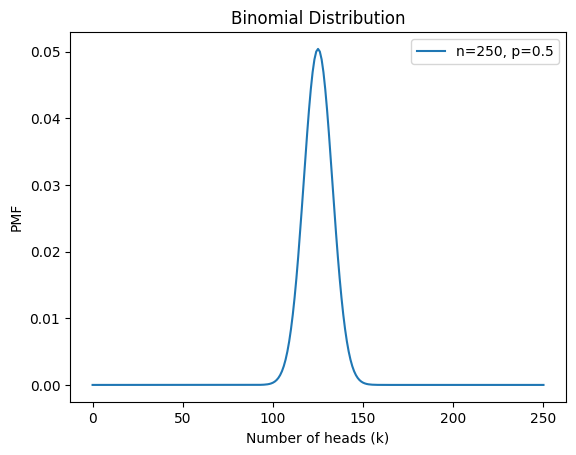

In [30]:
# | label: k
def make_binomial(n, p):
    ks = np.arange(n + 1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)


# heres what it looks like with n = 250 & p = 0.5
(pmf_k := make_binomial(n=250, p=0.5))
fig = plt.plot(pmf_k)
plt.title("Binomial Distribution")
plt.ylabel("PMF")
plt.xlabel("Number of heads (k)")
plt.legend(["n=250, p=0.5"], loc="upper right")


In [7]:
# | label: fig-cdf
# | fig-cap: "Plotting CDF"
# | fig-alt: "Posterior distribution for the Euro Problem"

hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250


In [8]:
def update_binomial(pmf, data):
    """Update pmf using binomial distribution"""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()


update_binomial(pmf, data)


In [9]:
# @fig-cdf
cumulative = pmf.cumsum()
